In [1]:
# embedding matice má v řádcích embeddingy (1 řádek - 1 token)
# vizualizovat umapem a olabelovat páry

In [2]:
checkpoint_path = "/mnt/raid/data/Hyner_Petr/rl/rl_basic_transformer/data/cc/8gjj7no2/checkpoints/epoch=1-step=900.ckpt"

In [3]:
import wandb
from tqdm import tqdm

In [4]:
import torch
from lightning import LightningModule
from models import GPT, GPTConfig, CausalSelfAttention
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

class NanoGPT(LightningModule):
    def __init__(
        self,
        vocab_size: int,
        block_size: int,
        n_layer: int = None,
        n_head: int = None,
        n_embd: int = None,
        dropout: float = 0.0,
        weight_decay: float = 0.1,
        learning_rate: float = 3e-4,
        betas: tuple = (0.9, 0.95)
    ):
        super().__init__()
        self.betas = betas
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.config = GPTConfig(vocab_size=vocab_size, block_size=block_size, n_layer=n_layer, n_head=n_head, n_embd=n_embd, dropout=dropout)
        self.gpt = GPT(self.config)

    def forward(self, idx: torch.Tensor, targets: torch.Tensor = None) -> torch.Tensor:
        return self.gpt(idx, targets)

    def get_attention_map(self, idx: torch.Tensor):
        """
        Get the attention map for a single example.
        """
        self.attention_map = None

        def hook_fn(module, input, output):
            self.attention_map = output[1].detach() 

        first_attn_layer = self.gpt.transformer.h[0].attn
        handle = first_attn_layer.register_forward_hook(hook_fn)

        # Forward pass
        with torch.no_grad():
            self(idx)

        # Remove the hook
        handle.remove()

        return self.attention_map
## FCE:

def load_trained_model(checkpoint_path, vocab_size, block_size, n_layer, n_head, n_embd):
    model = NanoGPT(
        vocab_size=vocab_size,
        block_size=block_size,
        n_layer=n_layer,
        n_head=n_head,
        n_embd=n_embd
    )
    
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    
    model.eval()
    
    return model
    
def load_data(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    return data

In [5]:
loaded_model = load_trained_model(
    checkpoint_path,
    vocab_size=80,
    block_size=8,
    n_layer=2,
    n_head=1,
    n_embd=128,
)
print("Model loaded from local checkpoint")

input_ids = torch.randint(0, 80, (1, 8))  # Random input
with torch.no_grad():
    output, _ = loaded_model(input_ids)
print("Output shape:", output.shape)

number of parameters: 0.41M
Model loaded from local checkpoint
Output shape: torch.Size([1, 1, 80])


In [6]:
data = load_data("new_data.pkl")
test_data = data["test"]

In [7]:
def inference_on_test_set(model, test_data):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = len(test_data)
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for sample in tqdm(test_data):
            input_ids = torch.tensor(sample['input']).unsqueeze(0)  # Add batch dimension
            true_output = sample['target_idx']
            
            input_ids = input_ids.to(next(model.parameters()).device)
            
            logits, _ = model(input_ids)
            predicted_output = logits.argmax(dim=-1).item()
            
            correct_predictions += (predicted_output == true_output)
            
            predictions.append(predicted_output)
            true_labels.append(true_output)
    
    accuracy = correct_predictions / total_samples
    return accuracy, predictions, true_labels

In [8]:
accuracy,_,_= inference_on_test_set(loaded_model, test_data)
accuracy

100%|██████████| 32000/32000 [00:35<00:00, 908.76it/s]


1.0

In [9]:
def inference_on_single_sample(model, sample):
    model.eval()  # Set the model to evaluation mode
    
    input_ids = torch.tensor(sample['input']).unsqueeze(0)  # Add batch dimension
    true_output = sample['target_idx']
    
    input_ids = input_ids.to(next(model.parameters()).device)
    
    with torch.no_grad():
        logits, _ = model(input_ids)
        predicted_output = logits.argmax(dim=-1).item()
    
    is_correct = (predicted_output == true_output)
    
    return is_correct, f"{predicted_output=}", f"{true_output=}"


In [10]:
loaded_model.gpt.transformer.wte.weight.shape

torch.Size([80, 128])

In [11]:
loaded_model.gpt.transformer.wte.weight

Parameter containing:
tensor([[ 0.0591,  0.0578, -0.0763,  ..., -0.0769,  0.0823, -0.0664],
        [ 0.0814,  0.0616, -0.0399,  ..., -0.0070,  0.0328, -0.0466],
        [ 0.0345,  0.0602, -0.0063,  ..., -0.0204,  0.0453, -0.0790],
        ...,
        [ 0.1256, -0.1671,  0.1500,  ...,  0.1287, -0.1250, -0.0990],
        [-0.1240, -0.1592, -0.1059,  ...,  0.1338,  0.1228, -0.1049],
        [ 0.0549,  0.0579, -0.0799,  ..., -0.0617,  0.0802, -0.0665]],
       requires_grad=True)

In [12]:
loaded_model.gpt.transformer.h[0].attn

CausalSelfAttention(
  (c_attn): Linear(in_features=128, out_features=384, bias=True)
  (c_proj): Linear(in_features=128, out_features=128, bias=True)
  (attn_dropout): Dropout(p=0.0, inplace=False)
  (resid_dropout): Dropout(p=0.0, inplace=False)
)

In [13]:
loaded_model

NanoGPT(
  (gpt): GPT(
    (transformer): ModuleDict(
      (wte): Embedding(80, 128)
      (wpe): Embedding(8, 128)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-1): 2 x Block(
          (ln_1): LayerNorm()
          (attn): CausalSelfAttention(
            (c_attn): Linear(in_features=128, out_features=384, bias=True)
            (c_proj): Linear(in_features=128, out_features=128, bias=True)
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
          )
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=128, out_features=512, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=512, out_features=128, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm()
    )
    (lm_head): Linear(in_features=128, out_features=80, bias=False)
  )
)

In [32]:
index = 28000

In [33]:
test_data[index]["input"]

[64, 46, 5, 68, 62, 4, 69]

In [34]:
test_data[index]["orig_idx"]

3

In [35]:
inference_on_single_sample(loaded_model, test_data[index])

(True, 'predicted_output=76', 'true_output=76')

torch.Size([1, 1, 7, 7])
torch.Size([7, 7])
tensor([[0.0000, 0.1510, 0.1449, 0.2046, 0.1505, 0.1932, 0.1557],
        [0.1734, 0.0000, 0.1704, 0.1722, 0.1614, 0.1663, 0.1562],
        [0.1542, 0.1579, 0.0000, 0.1323, 0.1243, 0.3009, 0.1303],
        [0.3129, 0.1067, 0.1519, 0.0000, 0.1016, 0.1662, 0.1606],
        [0.1307, 0.2210, 0.1751, 0.1337, 0.0000, 0.1788, 0.1606],
        [0.1713, 0.1634, 0.1807, 0.1550, 0.1673, 0.0000, 0.1623],
        [0.1475, 0.1518, 0.1260, 0.3198, 0.1016, 0.1531, 0.0000]])


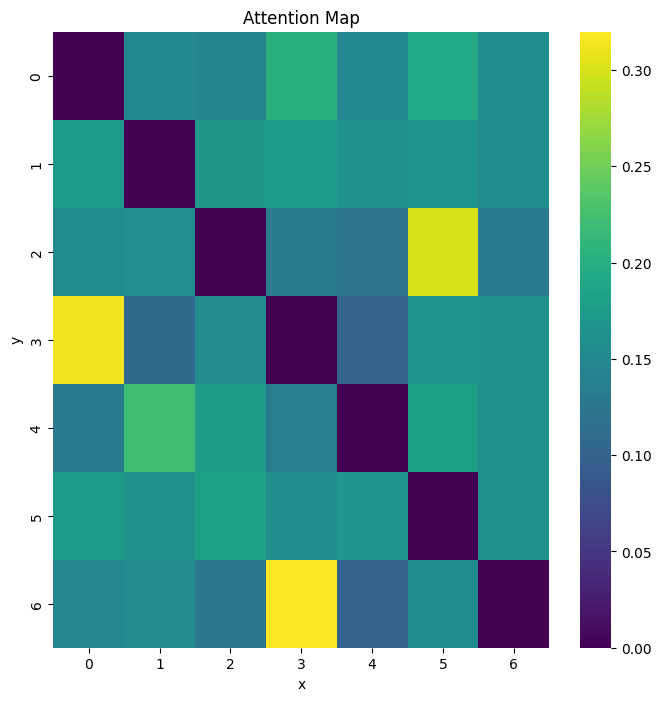

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def visualize_attention_map(model, input_ids):
    model.eval()
    with torch.no_grad():
        attention = model.get_attention_map(input_ids)
    print(attention.shape)
    attention = attention.squeeze()
    print(attention.shape)
    print(attention)

    plt.figure(figsize=(8, 8))
    sns.heatmap(attention, cmap='viridis')
    plt.title("Attention Map")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

input_ids = torch.tensor(test_data[index]["input"]).unsqueeze(0)
visualize_attention_map(loaded_model, input_ids)

In [19]:
embeddings = loaded_model.gpt.transformer.wte.weight
embeddings.shape

torch.Size([80, 128])

In [24]:
import umap
from sklearn.decomposition import PCA
embeddings = loaded_model.gpt.transformer.wte.weight
embeddings = embeddings.detach().numpy()[:73]

def get_embedding_umap(embeddings):
    reducer = umap.UMAP()
    umap_embeddings = reducer.fit_transform(embeddings)
    return umap_embeddings

def get_embedding_pca(embeddings):
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)
    return pca_embeddings

# Call the functions to get UMAP and PCA embeddings
umap_embeddings = get_embedding_umap(embeddings)
pca_embeddings = get_embedding_pca(embeddings)

# Print the shapes of the embeddings
print(f"UMAP embeddings shape: {umap_embeddings.shape}")
print(f"PCA embeddings shape: {pca_embeddings.shape}")


UMAP embeddings shape: (73, 2)
PCA embeddings shape: (73, 2)


In [25]:
embeddings

array([[ 0.05905068,  0.05781277, -0.07628789, ..., -0.07690966,
         0.08229019, -0.06641585],
       [ 0.08143721,  0.06164668, -0.03986395, ..., -0.00701799,
         0.03282579, -0.04659532],
       [ 0.03451728,  0.06018566, -0.00630728, ..., -0.02039369,
         0.04534436, -0.07904528],
       ...,
       [ 0.05550281,  0.07044397, -0.06586005, ..., -0.07191595,
         0.0744521 , -0.02323194],
       [ 0.06221993,  0.07890154, -0.01377828, ..., -0.02080587,
         0.05579889, -0.03548157],
       [ 0.09060319,  0.03274804, -0.02942335, ..., -0.05374441,
         0.06916909,  0.0186925 ]], dtype=float32)

In [26]:
embeddings.shape

(73, 128)

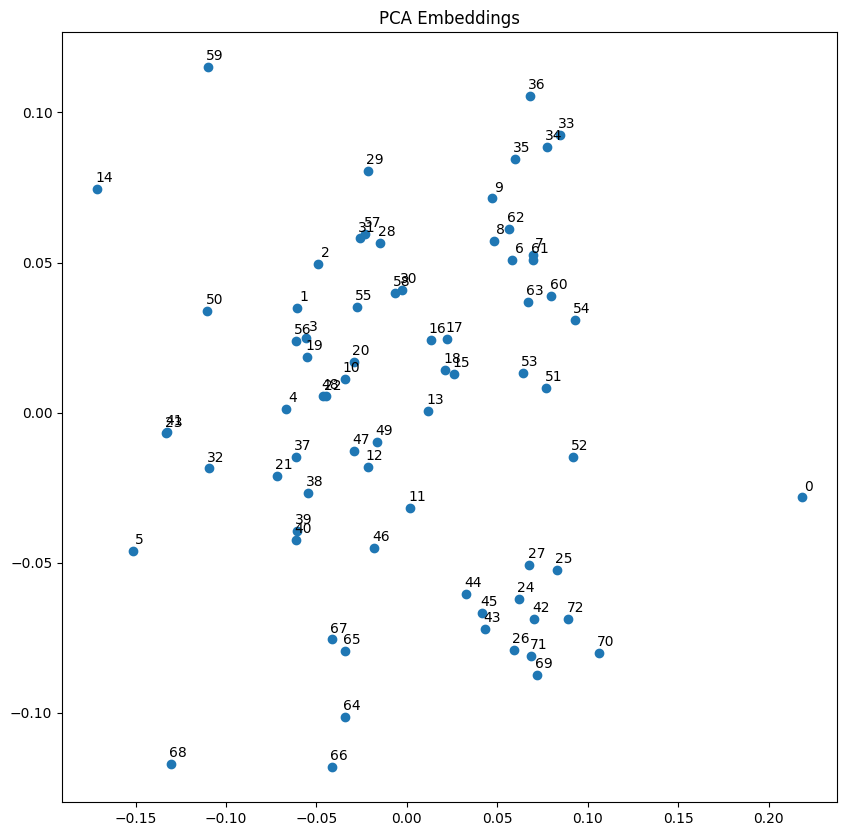

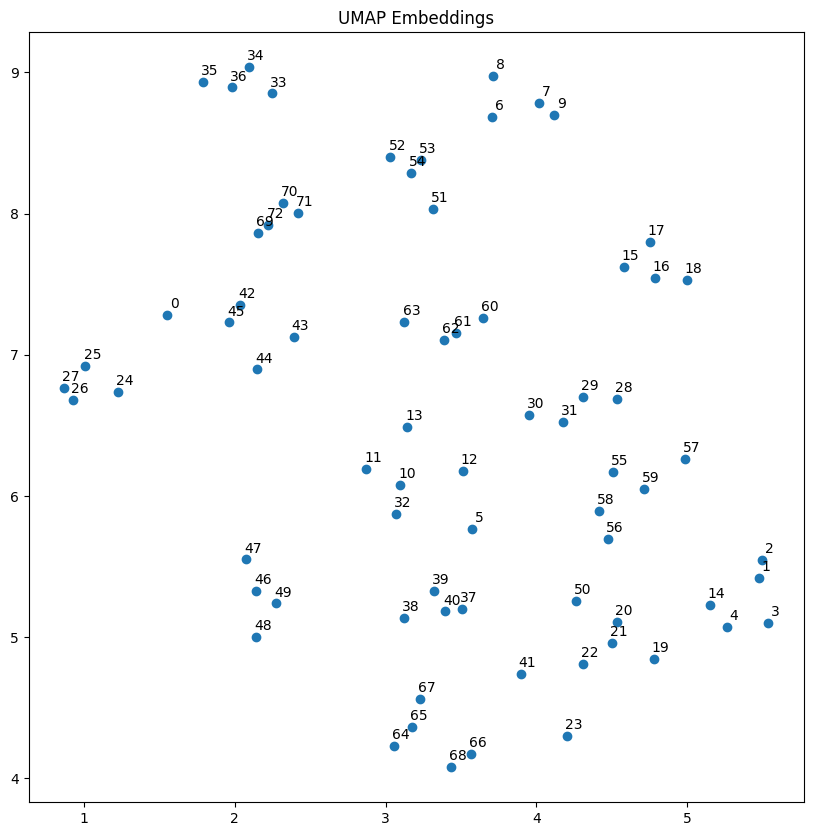

In [27]:
import matplotlib.pyplot as plt

def visualize_embeddings(embeddings, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])
    plt.title(title)
    labels = list(range(len(embeddings)))
    for i in range(len(embeddings)):
        plt.annotate(labels[i], (embeddings[i, 0], embeddings[i, 1]), textcoords="offset points", xytext=(5,5), ha='center')
    plt.show()

# Call the function to visualize the PCA embeddings
visualize_embeddings(pca_embeddings, "PCA Embeddings")
visualize_embeddings(umap_embeddings, "UMAP Embeddings")